# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

print('Libraries Loaded')

Libraries Loaded


# Utilities

In [2]:
def read_file(path):
    '''
    Returns the dataframe which is read from the excel file present in the path specified. 
    
    Parameters:
        path (str) : The path of the file
    
    Returns:
        df (float) : The dataframe which is created after reading the file.
    '''
    df= pd.read_excel(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    '''
    Returns the prepared data based on the lag and look ahead
    
    Parameters:
        X          (float): The independent variables of the data
        y          (float): The dependent variables of the data
        time_steps (int)  : The lag that is being used to lookback
        ts_range   (int)  : The lookahead for the data
    
    Returns:
        Xs (float) : The numpy array of the input variable
        ys (float) : The numpy array of the output variable 
    '''
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    '''
    Returns the training and testing data
    
    Parameters:
        df (float): The whole dataframe containing the independent and dependent variables
        output(str): The output variable 
        lag (int): The lag that needs to be applied for the data
        duration (int): The duration that is being considered as output
        ts (float): The percentage of training data
    
    Returns:
        x_train (float): The training data of independent variable 
        x_test (float): The testing data of independent variable
        y_train (float): The training data of the depenedent variable 
        y_test (float): The testing data of the dependent variable 
    '''
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    Attention layer for the neural networks.
    
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being inspired from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

# Data Preparation

In [3]:
## Specifying the source path
src = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Data'
filename = r'Pave_data_cleaned.xlsx'

## Specifying the destination path
dest = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Solutions\Six Hours Lag'

## Reading the file
df = read_file(os.path.join(src,filename))

(10896, 7)
   Year  Month  Day  Hour  Temp  Solar  Pavement
0  2009     11    1     1   8.4    0.0  9.333333
1  2009     11    1     2   8.3    0.0  8.933333
2  2009     11    1     3   7.9    0.0  8.700000
3  2009     11    1     4   7.6    0.0  8.533333
4  2009     11    1     5   6.9    0.0  8.533333


In [4]:
## Creating the training and testing data
x_train,x_test,y_train,y_test,scaler = splitter(df[['Temp','Pavement']],['Pavement'],6,6,0.8)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(8716, 2) (2180, 2)
The shape of x_train is (8704, 6, 2) and x_test is (2168, 6, 2)
The shape of y_train is (8704, 6) and y_test is (2168, 6)


# Models

## LSTM Model

In [5]:
## Creating the prelimaries 

filepath_simple = 'simple_lstm.hdf5'
filepath_attention = 'attention_lstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [6]:
## Simple LSTM
K.clear_session()
simple_lstm = keras.Sequential()
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Flatten())
simple_lstm.add(keras.layers.Dense(512, activation='relu'))
simple_lstm.add(keras.layers.Dense(128, activation='relu'))
simple_lstm.add(keras.layers.Dense(64, activation='relu'))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.Dense(32))
simple_lstm.add(keras.layers.Dense(6))

simple_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

Creating a new directory......
New Directory Created
Epoch 1/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0146 - mae: 0.0852 - val_loss: 0.0023 - val_mae: 0.0370
Epoch 2/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0069 - mae: 0.0611 - val_loss: 0.0022 - val_mae: 0.0365
Epoch 3/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0056 - mae: 0.0552 - val_loss: 0.0022 - val_mae: 0.0367
Epoch 4/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0046 - mae: 0.0497 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 5/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0041 - mae: 0.0459 - val_loss: 0.0014 - val_mae: 0.0272
Epoch 6/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0036 - mae: 0.0431 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 7/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0035 - mae: 0.0426 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 8/200
245/

245/245 [==============================] - 1s 5ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 8.0539e-04 - val_mae: 0.0210
Epoch 120/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0278 - val_loss: 8.6833e-04 - val_mae: 0.0213
Epoch 121/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0282 - val_loss: 9.8666e-04 - val_mae: 0.0240
Epoch 122/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0015 - mae: 0.0273 - val_loss: 7.7944e-04 - val_mae: 0.0201
Epoch 123/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 7.9892e-04 - val_mae: 0.0199
Epoch 124/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 7.6120e-04 - val_mae: 0.0196
Epoch 125/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0015 - mae: 0.0274 - val_loss: 0.0013 - val_mae: 0.0271
Epoch 126/200
245/245 [======================

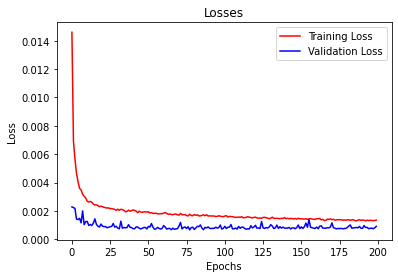

The Mean Squared Error is: 12.577021916561455


In [7]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = simple_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

simple_lstm.load_weights(filepath_simple)
preds = simple_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [8]:
## Attention model
K.clear_session()
atten_lstm = keras.Sequential()
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Flatten())
atten_lstm.add(keras.layers.Dense(512, activation='relu'))
atten_lstm.add(keras.layers.Dense(128, activation='relu'))
atten_lstm.add(keras.layers.Dense(64, activation='relu'))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.Dense(32))
atten_lstm.add(keras.layers.Dense(6))

atten_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

Directory present
Epoch 1/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0169 - mae: 0.0914 - val_loss: 0.0028 - val_mae: 0.0430
Epoch 2/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0071 - mae: 0.0621 - val_loss: 0.0024 - val_mae: 0.0375
Epoch 3/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0063 - mae: 0.0581 - val_loss: 0.0021 - val_mae: 0.0366
Epoch 4/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0053 - mae: 0.0531 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 5/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0044 - mae: 0.0484 - val_loss: 0.0015 - val_mae: 0.0302
Epoch 6/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0038 - mae: 0.0447 - val_loss: 0.0013 - val_mae: 0.0271
Epoch 7/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0037 - mae: 0.0439 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 8/200
245/245 [==============================

245/245 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0283 - val_loss: 7.7175e-04 - val_mae: 0.0203
Epoch 120/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0281 - val_loss: 7.6365e-04 - val_mae: 0.0198
Epoch 121/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0015 - mae: 0.0277 - val_loss: 8.8329e-04 - val_mae: 0.0218
Epoch 122/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0280 - val_loss: 7.3877e-04 - val_mae: 0.0194
Epoch 123/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 8.1677e-04 - val_mae: 0.0204
Epoch 124/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0282 - val_loss: 8.8620e-04 - val_mae: 0.0230
Epoch 125/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0280 - val_loss: 7.8148e-04 - val_mae: 0.0212
Epoch 126/200
245/245 [==================

245/245 [==============================] - 1s 5ms/step - loss: 0.0014 - mae: 0.0266 - val_loss: 8.1443e-04 - val_mae: 0.0210
Epoch 179/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0014 - mae: 0.0264 - val_loss: 8.0422e-04 - val_mae: 0.0199
Epoch 180/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 8.3764e-04 - val_mae: 0.0212
Epoch 181/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0014 - mae: 0.0263 - val_loss: 7.2208e-04 - val_mae: 0.0189
Epoch 182/200
245/245 [==============================] - 1s 5ms/step - loss: 0.0014 - mae: 0.0263 - val_loss: 8.6961e-04 - val_mae: 0.0212
Epoch 183/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0263 - val_loss: 7.8018e-04 - val_mae: 0.0203
Epoch 184/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0267 - val_loss: 7.4548e-04 - val_mae: 0.0201
Epoch 185/200
245/245 [==================

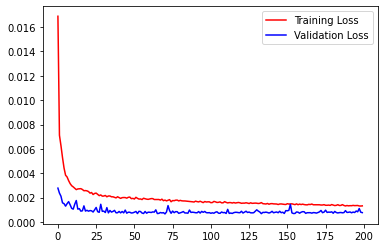

The Mean Squared Error is: 12.074794783720996


In [9]:
## Saving the result file to the folder of the model

try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = atten_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_lstm.load_weights(filepath_attention)
preds = atten_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)

wk.save(f'LSTM Result.xls')

## CNN-LSTM

In [13]:
## Creating the prelimaries 

filepath_simple = 'simple_cnnlstm.hdf5'
filepath_attention = 'attention_cnnlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [14]:
## Simple CNN-LSTM model
K.clear_session()
simple_cnnlstm = keras.Sequential()
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.Flatten())
simple_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(32))
simple_cnnlstm.add(keras.layers.Dense(6))

simple_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Directory present
Epoch 1/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0290 - mae: 0.1144 - val_loss: 0.0026 - val_mae: 0.0431
Epoch 2/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0050 - mae: 0.0514 - val_loss: 0.0018 - val_mae: 0.0327
Epoch 3/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0043 - mae: 0.0472 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 4/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0040 - mae: 0.0450 - val_loss: 0.0014 - val_mae: 0.0283
Epoch 5/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0036 - mae: 0.0425 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 6/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0032 - mae: 0.0401 - val_loss: 0.0013 - val_mae: 0.0267
Epoch 7/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0030 - mae: 0.0383 - val_loss: 0.0011 - val_mae: 0.0248
Epoch 8/200
245/245 [==============================

245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0223 - val_loss: 7.6007e-04 - val_mae: 0.0193
Epoch 120/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0226 - val_loss: 7.5453e-04 - val_mae: 0.0196
Epoch 121/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 6.8635e-04 - val_mae: 0.0187
Epoch 122/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0225 - val_loss: 6.7151e-04 - val_mae: 0.0180
Epoch 123/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0224 - val_loss: 7.2013e-04 - val_mae: 0.0189
Epoch 124/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0229 - val_loss: 6.9614e-04 - val_mae: 0.0191
Epoch 125/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0229 - val_loss: 6.7366e-04 - val_mae: 0.0185
Epoch 126/200
245/245 [==================

245/245 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0213 - val_loss: 7.8524e-04 - val_mae: 0.0193
Epoch 179/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0211 - val_loss: 7.9020e-04 - val_mae: 0.0196
Epoch 180/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0211 - val_loss: 6.9525e-04 - val_mae: 0.0184
Epoch 181/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0215 - val_loss: 8.5844e-04 - val_mae: 0.0214
Epoch 182/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0214 - val_loss: 7.4552e-04 - val_mae: 0.0185
Epoch 183/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0215 - val_loss: 7.2184e-04 - val_mae: 0.0187
Epoch 184/200
245/245 [==============================] - 1s 3ms/step - loss: 0.0010 - mae: 0.0214 - val_loss: 7.2700e-04 - val_mae: 0.0187
Epoch 185/200
245/245 [==================

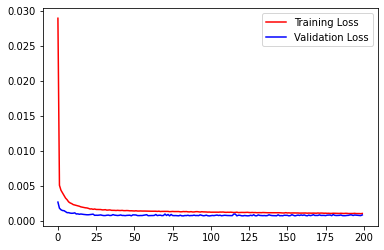

The Mean Squared Error is: 11.704137796827624


In [15]:
## Saving the result file to the folder of the model

try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

history = simple_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_cnnlstm.load_weights(filepath_simple)
preds = simple_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [16]:
## Attention model
K.clear_session()
atten_cnnlstm = keras.Sequential()
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(attention(return_sequences=True))
atten_cnnlstm.add(keras.layers.Flatten())
atten_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(32))
atten_cnnlstm.add(keras.layers.Dense(6))

atten_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Directory present
Epoch 1/200
245/245 [==============================] - 1s 6ms/step - loss: 0.0331 - mae: 0.1249 - val_loss: 0.0025 - val_mae: 0.0396
Epoch 2/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0053 - mae: 0.0532 - val_loss: 0.0018 - val_mae: 0.0325
Epoch 3/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0045 - mae: 0.0478 - val_loss: 0.0016 - val_mae: 0.0305
Epoch 4/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0041 - mae: 0.0459 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 5/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0038 - mae: 0.0440 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 6/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0035 - mae: 0.0424 - val_loss: 0.0013 - val_mae: 0.0278
Epoch 7/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0033 - mae: 0.0405 - val_loss: 0.0013 - val_mae: 0.0270
Epoch 8/200
245/245 [==============================

Epoch 61/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0015 - mae: 0.0256 - val_loss: 7.0103e-04 - val_mae: 0.0189
Epoch 62/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0015 - mae: 0.0257 - val_loss: 7.4426e-04 - val_mae: 0.0194
Epoch 63/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0015 - mae: 0.0257 - val_loss: 7.6743e-04 - val_mae: 0.0201
Epoch 64/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0251 - val_loss: 8.3656e-04 - val_mae: 0.0216
Epoch 65/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0015 - mae: 0.0254 - val_loss: 8.5244e-04 - val_mae: 0.0207
Epoch 66/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0251 - val_loss: 7.2500e-04 - val_mae: 0.0190
Epoch 67/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0015 - mae: 0.0256 - val_loss: 8.7442e-04 - val_mae: 0.0215
Epoch 68/200
245/245 [============

245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0222 - val_loss: 7.4121e-04 - val_mae: 0.0188
Epoch 180/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 7.3238e-04 - val_mae: 0.0186
Epoch 181/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0221 - val_loss: 8.2951e-04 - val_mae: 0.0213
Epoch 182/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 7.7512e-04 - val_mae: 0.0204
Epoch 183/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 7.2688e-04 - val_mae: 0.0185
Epoch 184/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0223 - val_loss: 7.0203e-04 - val_mae: 0.0183
Epoch 185/200
245/245 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0223 - val_loss: 8.0539e-04 - val_mae: 0.0209
Epoch 186/200
245/245 [==================

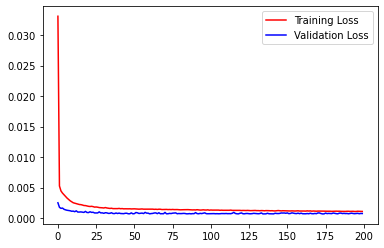

The Mean Squared Error is: 11.669131477071934


In [17]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

history = atten_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_cnnlstm.load_weights(filepath_attention)
preds = atten_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('CNN-LStM Results.xls')

## ConvLSTM Model

In [18]:
## Creating the prelimaries 

filepath_simple = 'simple_convlstm.hdf5'
filepath_attention = 'attention_convlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [19]:
## Reshaping the training and testing data to suit the convlstm model
x_train_conv =x_train.reshape(x_train.shape[0], 1, 1, x_train.shape[1], x_train.shape[2])
x_test_conv = x_test.reshape(x_test.shape[0], 1, 1, x_test.shape[1], x_test.shape[2])

In [21]:
## Simple ConvLSTM model
K.clear_session()
simple_convlstm = keras.Sequential()
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
simple_convlstm.add(keras.layers.Flatten())
simple_convlstm.add(keras.layers.Dense(512, activation='relu'))
simple_convlstm.add(keras.layers.Dense(128, activation='relu'))
simple_convlstm.add(keras.layers.Dense(64, activation='relu'))
simple_convlstm.add(keras.layers.Dense(32))
simple_convlstm.add(keras.layers.Dense(6))

simple_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Creating a new directory......
New Directory Created
Epoch 1/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0517 - mae: 0.1711 - val_loss: 0.0076 - val_mae: 0.0711
Epoch 2/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0069 - mae: 0.0620 - val_loss: 0.0025 - val_mae: 0.0404
Epoch 3/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0056 - mae: 0.0545 - val_loss: 0.0020 - val_mae: 0.0351
Epoch 4/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0051 - mae: 0.0517 - val_loss: 0.0018 - val_mae: 0.0313
Epoch 5/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0048 - mae: 0.0497 - val_loss: 0.0017 - val_mae: 0.0306
Epoch 6/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0045 - mae: 0.0483 - val_loss: 0.0016 - val_mae: 0.0305
Epoch 7/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0041 - mae: 0.0464 - val_loss: 0.0017 - val_mae: 0.0301
Epoch 8/2

Epoch 61/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0021 - mae: 0.0314 - val_loss: 0.0010 - val_mae: 0.0241
Epoch 62/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0021 - mae: 0.0316 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 63/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0021 - mae: 0.0316 - val_loss: 0.0010 - val_mae: 0.0237
Epoch 64/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0021 - mae: 0.0312 - val_loss: 0.0011 - val_mae: 0.0240
Epoch 65/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0021 - mae: 0.0313 - val_loss: 9.9034e-04 - val_mae: 0.0232
Epoch 66/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0021 - mae: 0.0313 - val_loss: 0.0011 - val_mae: 0.0252
Epoch 67/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0021 - mae: 0.0316 - val_loss: 9.7380e-04 - val_mae: 0.0228
Epoch 68/200
245/245 [=========================

245/245 [==============================] - 6s 24ms/step - loss: 0.0014 - mae: 0.0249 - val_loss: 7.3319e-04 - val_mae: 0.0192
Epoch 179/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0014 - mae: 0.0244 - val_loss: 7.2280e-04 - val_mae: 0.0190
Epoch 180/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0014 - mae: 0.0249 - val_loss: 7.5251e-04 - val_mae: 0.0192
Epoch 181/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0014 - mae: 0.0248 - val_loss: 7.8538e-04 - val_mae: 0.0210
Epoch 182/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0014 - mae: 0.0247 - val_loss: 7.9875e-04 - val_mae: 0.0201
Epoch 183/200
245/245 [==============================] - 6s 23ms/step - loss: 0.0014 - mae: 0.0247 - val_loss: 7.4890e-04 - val_mae: 0.0197
Epoch 184/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0014 - mae: 0.0246 - val_loss: 7.3106e-04 - val_mae: 0.0192
Epoch 185/200
245/245 [===========

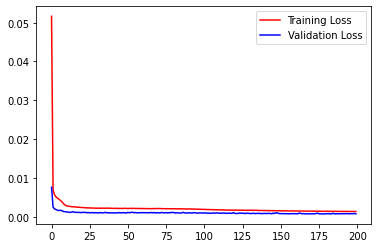

The Mean Squared Error is: 12.826096480881398


In [22]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = simple_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_convlstm.load_weights(filepath_simple)
preds = simple_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [24]:
## Attention model
K.clear_session()
atten_convlstm = keras.Sequential()
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
atten_convlstm.add(attention(return_sequences=True))
atten_convlstm.add(keras.layers.Flatten())
atten_convlstm.add(keras.layers.Dense(512, activation='relu'))
atten_convlstm.add(keras.layers.Dense(128, activation='relu'))
atten_convlstm.add(keras.layers.Dense(64, activation='relu'))
atten_convlstm.add(keras.layers.Dense(32))
atten_convlstm.add(keras.layers.Dense(6))

atten_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Directory present
Epoch 1/200
245/245 [==============================] - 6s 26ms/step - loss: 0.0519 - mae: 0.1716 - val_loss: 0.0102 - val_mae: 0.0844
Epoch 2/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0070 - mae: 0.0622 - val_loss: 0.0023 - val_mae: 0.0365
Epoch 3/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0054 - mae: 0.0535 - val_loss: 0.0020 - val_mae: 0.0333
Epoch 4/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0051 - mae: 0.0514 - val_loss: 0.0018 - val_mae: 0.0319
Epoch 5/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0047 - mae: 0.0496 - val_loss: 0.0017 - val_mae: 0.0312
Epoch 6/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0046 - mae: 0.0488 - val_loss: 0.0017 - val_mae: 0.0309
Epoch 7/200
245/245 [==============================] - 6s 24ms/step - loss: 0.0044 - mae: 0.0478 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 8/200
245/245 [=======================

245/245 [==============================] - 7s 27ms/step - loss: 0.0018 - mae: 0.0287 - val_loss: 9.0164e-04 - val_mae: 0.0220
Epoch 121/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0017 - mae: 0.0284 - val_loss: 8.7092e-04 - val_mae: 0.0216
Epoch 122/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0018 - mae: 0.0286 - val_loss: 8.8728e-04 - val_mae: 0.0218
Epoch 123/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0017 - mae: 0.0285 - val_loss: 9.0947e-04 - val_mae: 0.0219
Epoch 124/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0017 - mae: 0.0283 - val_loss: 9.3112e-04 - val_mae: 0.0226
Epoch 125/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0017 - mae: 0.0282 - val_loss: 9.6599e-04 - val_mae: 0.0226
Epoch 126/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0017 - mae: 0.0281 - val_loss: 8.5092e-04 - val_mae: 0.0213
Epoch 127/200
245/245 [===========

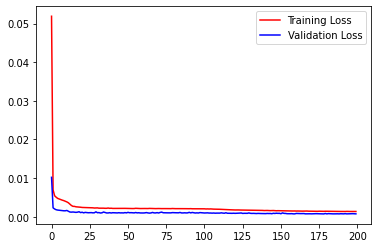

The Mean Squared Error is: 12.677123526406021


In [25]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = atten_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_convlstm.load_weights(filepath_attention)
preds = atten_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('ConvLSTM Results.xls')

## Seq2Seq Model

In [26]:
## Creating the prelimaries 

filepath_simple = 'simple_seq2seq.hdf5'
filepath_attention = 'attention_seq2seq.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [27]:
## Reshaping the training data to suit Seq2Seq model
y_train_seq = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [28]:
## Simple Model
K.clear_session()
input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

### --------------------------------Encoder Section -----------------------------------------------###
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=False, return_state=True)(encoder_third)

###---------------------------------Decorder Section-----------------------------------------------###
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first,initial_state=[encoder_fourth,encoder_fourth_s2])
decoder_third = keras.layers.LSTM(128,return_sequences=True)(decoder_second)
decoder_fourth = keras.layers.LSTM(128,return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128,return_sequences=True)(decoder_fourth)
print(decoder_fifth)

###--------------------------------Output Section-------------------------------------------------###
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_fifth)

simple_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=0.001)
simple_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
simple_seq.summary()

Tensor("lstm_7/PartitionedCall:1", shape=(None, 6, 128), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       67072       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 6, 128)       131584      lstm_1[0][0]                     
_______________

Creating a new directory......
New Directory Created
Epoch 1/200
245/245 [==============================] - 4s 16ms/step - loss: 0.0176 - mae: 0.0913 - val_loss: 0.0024 - val_mae: 0.0371
Epoch 2/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0061 - mae: 0.0571 - val_loss: 0.0024 - val_mae: 0.0398
Epoch 3/200
245/245 [==============================] - 3s 11ms/step - loss: 0.0048 - mae: 0.0499 - val_loss: 0.0016 - val_mae: 0.0297
Epoch 4/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0031 - mae: 0.0400 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 5/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0024 - mae: 0.0347 - val_loss: 9.7129e-04 - val_mae: 0.0232
Epoch 6/200
245/245 [==============================] - 3s 11ms/step - loss: 0.0021 - mae: 0.0326 - val_loss: 9.1942e-04 - val_mae: 0.0225
Epoch 7/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0021 - mae: 0.0324 - val_loss: 9.4315e-04 - val_mae: 0.02

Epoch 60/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 7.2348e-04 - val_mae: 0.0189
Epoch 61/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0012 - mae: 0.0230 - val_loss: 7.3337e-04 - val_mae: 0.0188
Epoch 62/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 8.4197e-04 - val_mae: 0.0202
Epoch 63/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0012 - mae: 0.0229 - val_loss: 6.9913e-04 - val_mae: 0.0182
Epoch 64/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 7.8462e-04 - val_mae: 0.0205
Epoch 65/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0012 - mae: 0.0233 - val_loss: 7.7873e-04 - val_mae: 0.0190
Epoch 66/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0012 - mae: 0.0227 - val_loss: 7.7900e-04 - val_mae: 0.0202
Epoch 67/200
245/245 [=====

Epoch 118/200
245/245 [==============================] - 2s 10ms/step - loss: 6.8675e-04 - mae: 0.0179 - val_loss: 8.0755e-04 - val_mae: 0.0193
Epoch 119/200
245/245 [==============================] - 3s 10ms/step - loss: 7.0179e-04 - mae: 0.0183 - val_loss: 8.3242e-04 - val_mae: 0.0195
Epoch 120/200
245/245 [==============================] - 3s 10ms/step - loss: 6.9976e-04 - mae: 0.0181 - val_loss: 8.6698e-04 - val_mae: 0.0207
Epoch 121/200
245/245 [==============================] - 2s 10ms/step - loss: 6.6415e-04 - mae: 0.0176 - val_loss: 8.2210e-04 - val_mae: 0.0196
Epoch 122/200
245/245 [==============================] - 2s 10ms/step - loss: 7.0040e-04 - mae: 0.0182 - val_loss: 9.0108e-04 - val_mae: 0.0212
Epoch 123/200
245/245 [==============================] - 3s 10ms/step - loss: 6.9663e-04 - mae: 0.0183 - val_loss: 7.8961e-04 - val_mae: 0.0191
Epoch 124/200
245/245 [==============================] - 2s 10ms/step - loss: 6.5115e-04 - mae: 0.0176 - val_loss: 8.8006e-04 - val_mae:

Epoch 176/200
245/245 [==============================] - 2s 10ms/step - loss: 1.8042e-04 - mae: 0.0099 - val_loss: 0.0010 - val_mae: 0.0218
Epoch 177/200
245/245 [==============================] - 2s 10ms/step - loss: 1.6830e-04 - mae: 0.0096 - val_loss: 9.6976e-04 - val_mae: 0.0211
Epoch 178/200
245/245 [==============================] - 2s 9ms/step - loss: 1.7552e-04 - mae: 0.0097 - val_loss: 0.0010 - val_mae: 0.0225
Epoch 179/200
245/245 [==============================] - 2s 9ms/step - loss: 3.2269e-04 - mae: 0.0126 - val_loss: 0.0011 - val_mae: 0.0234
Epoch 180/200
245/245 [==============================] - 2s 9ms/step - loss: 3.9334e-04 - mae: 0.0140 - val_loss: 9.4576e-04 - val_mae: 0.0216
Epoch 181/200
245/245 [==============================] - 2s 10ms/step - loss: 2.5726e-04 - mae: 0.0115 - val_loss: 0.0011 - val_mae: 0.0222
Epoch 182/200
245/245 [==============================] - 2s 9ms/step - loss: 1.8397e-04 - mae: 0.0099 - val_loss: 0.0010 - val_mae: 0.0220
Epoch 183/200
24

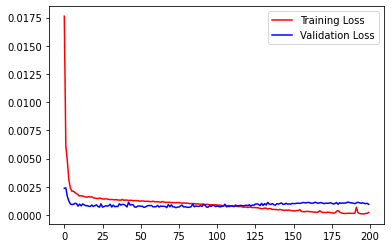

(2168, 6)
The Mean Squared Error is: 11.562320751968961


In [29]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Seq2Seq')
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('New Directory Created')

history = simple_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_seq.load_weights(filepath_simple)
preds = simple_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [30]:
## Attention Model
K.clear_session()

input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

###----------------------------------------Encoder Section------------------------------------------###
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=True,return_state=True)(encoder_third)

###-----------------------------------------Decoder Section------------------------------------------###
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth_s1)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first, initial_state=[encoder_fourth_s1, encoder_fourth_s2])

attention = keras.layers.dot([decoder_second, encoder_fourth], axes=[2, 2])
attention = keras.layers.Activation('softmax')(attention)
context = keras.layers.dot([attention, encoder_fourth], axes=[2, 1])

decoder_third = keras.layers.concatenate([context, decoder_second])

decoder_fourth = keras.layers.LSTM(128, return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128, return_sequences=True)(decoder_fourth)
decoder_sixth = keras.layers.LSTM(128, return_sequences=True)(decoder_fifth)

###-----------------------------------------Output Section-----------------------------------------###
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_sixth)

atten_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=0.0001)
atten_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
atten_seq.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       67072       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 6, 128)       131584      lstm_1[0][0]                     
_______________________________________________________________________________________

Directory present
Epoch 1/200
245/245 [==============================] - 4s 17ms/step - loss: 0.0475 - mae: 0.1660 - val_loss: 0.0035 - val_mae: 0.0474
Epoch 2/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0071 - mae: 0.0621 - val_loss: 0.0030 - val_mae: 0.0450
Epoch 3/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0065 - mae: 0.0590 - val_loss: 0.0026 - val_mae: 0.0404
Epoch 4/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0062 - mae: 0.0573 - val_loss: 0.0025 - val_mae: 0.0379
Epoch 5/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0061 - mae: 0.0568 - val_loss: 0.0023 - val_mae: 0.0367
Epoch 6/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0061 - mae: 0.0569 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 7/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0059 - mae: 0.0558 - val_loss: 0.0025 - val_mae: 0.0403
Epoch 8/200
245/245 [========================

245/245 [==============================] - 3s 11ms/step - loss: 0.0015 - mae: 0.0263 - val_loss: 7.6209e-04 - val_mae: 0.0197
Epoch 121/200
245/245 [==============================] - 3s 11ms/step - loss: 0.0015 - mae: 0.0260 - val_loss: 7.6561e-04 - val_mae: 0.0205
Epoch 122/200
245/245 [==============================] - 3s 11ms/step - loss: 0.0015 - mae: 0.0260 - val_loss: 7.1518e-04 - val_mae: 0.0195
Epoch 123/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0015 - mae: 0.0261 - val_loss: 7.8662e-04 - val_mae: 0.0207
Epoch 124/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0015 - mae: 0.0260 - val_loss: 8.3362e-04 - val_mae: 0.0212
Epoch 125/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 8.7334e-04 - val_mae: 0.0226
Epoch 126/200
245/245 [==============================] - 3s 11ms/step - loss: 0.0015 - mae: 0.0259 - val_loss: 8.3063e-04 - val_mae: 0.0210
Epoch 127/200
245/245 [===========

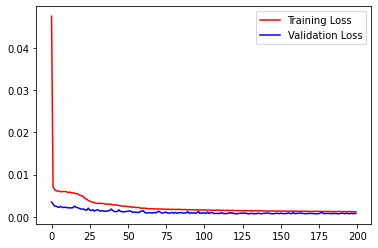

(2168, 6)
The Mean Squared Error is: 13.035554989125762


In [31]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Seq2Seq')
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('New Directory Created')

history = atten_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_seq.load_weights(filepath_attention)
preds = atten_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('Seq2Seq Results.xls')

## Wavenet Model

In [5]:
## Creating the prelimaries 

filepath_simple = 'simple_wavenet.hdf5'
filepath_attention = 'attention_wavenet.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [6]:
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = keras.layers.Conv1D(64, 1, padding='same')(x) 
    x_f = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = keras.layers.Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(z)

    x = keras.layers.Add()([x, z])    

    skips.append(z)

out = keras.layers.Activation('relu')(keras.layers.Add()(skips)) 
out = keras.layers.Conv1D(128, 1, padding='same')(out)
out = keras.layers.Activation('relu')(out)
out = keras.layers.Dropout(0.4)(out)
out = keras.layers.Conv1D(1, 1, padding='same')(out)

out = keras.layers.Flatten()(out)
out = keras.layers.Dense(6)(out)

simple_wavenet = keras.Model(inputs, out)

simple_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])


In [7]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Wavenet'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Wavenet')
    os.chdir(os.path.join(dest,'Wavenet'))
    print('New Directory Created')

history = simple_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_wavenet.load_weights(filepath_simple)
preds = simple_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


Directory present
(2168, 6)
The Mean Squared Error is: 13.390524851173161


In [8]:
## Attention model
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = Conv1D(64, 1, padding='same')(x) 
    x_f = Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = Conv1D(64, 1, padding='same', activation='relu')(z)

    x = Add()([x, z])    

    skips.append(z)

out = Activation('relu')(keras.layers.Add()(skips)) 
out = attention(return_sequences=True)(out)
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(0.4)(out)
out = Conv1D(1, 1, padding='same')(out)
# out = attention(return_sequences=True)(out)
out = Flatten()(out)
out = Dense(6)(out)

atten_wavenet = keras.Model(inputs, out)

atten_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
atten_wavenet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 6, 64)        192         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 6, 128)       16512       conv1d_30[0][0]                  
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 6, 128)       16512       conv1d_30[0][0]                  
_______________________________________________________________________________________

Directory present
Epoch 1/200
245/245 [==============================] - 3s 11ms/step - loss: 0.0280 - mae: 0.1155 - val_loss: 0.0018 - val_mae: 0.0325
Epoch 2/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0058 - mae: 0.0565 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 3/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0044 - mae: 0.0495 - val_loss: 0.0014 - val_mae: 0.0279
Epoch 4/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0035 - mae: 0.0438 - val_loss: 0.0019 - val_mae: 0.0332
Epoch 5/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0033 - mae: 0.0422 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 6/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0032 - mae: 0.0412 - val_loss: 0.0013 - val_mae: 0.0261
Epoch 7/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0029 - mae: 0.0391 - val_loss: 0.0011 - val_mae: 0.0246
Epoch 8/200
245/245 [=============================

Epoch 61/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0013 - mae: 0.0256 - val_loss: 8.2783e-04 - val_mae: 0.0205
Epoch 62/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 9.9695e-04 - val_mae: 0.0232
Epoch 63/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 8.6600e-04 - val_mae: 0.0208
Epoch 64/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 9.2357e-04 - val_mae: 0.0214
Epoch 65/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 8.1154e-04 - val_mae: 0.0200
Epoch 66/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - mae: 0.0249 - val_loss: 7.9547e-04 - val_mae: 0.0207
Epoch 67/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0011 - val_mae: 0.0247
Epoch 68/200
245/245 [================

245/245 [==============================] - 2s 7ms/step - loss: 8.8576e-04 - mae: 0.0213 - val_loss: 8.8061e-04 - val_mae: 0.0212
Epoch 121/200
245/245 [==============================] - 2s 7ms/step - loss: 8.4610e-04 - mae: 0.0207 - val_loss: 9.3671e-04 - val_mae: 0.0220
Epoch 122/200
245/245 [==============================] - 2s 7ms/step - loss: 8.5460e-04 - mae: 0.0209 - val_loss: 9.2743e-04 - val_mae: 0.0212
Epoch 123/200
245/245 [==============================] - 2s 7ms/step - loss: 8.8343e-04 - mae: 0.0211 - val_loss: 8.7462e-04 - val_mae: 0.0213
Epoch 124/200
245/245 [==============================] - 2s 7ms/step - loss: 9.3640e-04 - mae: 0.0219 - val_loss: 0.0011 - val_mae: 0.0244
Epoch 125/200
245/245 [==============================] - 2s 7ms/step - loss: 8.6624e-04 - mae: 0.0212 - val_loss: 9.4700e-04 - val_mae: 0.0223
Epoch 126/200
245/245 [==============================] - 2s 7ms/step - loss: 8.4867e-04 - mae: 0.0209 - val_loss: 0.0011 - val_mae: 0.0234
Epoch 127/200
245/245

245/245 [==============================] - 2s 7ms/step - loss: 6.3036e-04 - mae: 0.0181 - val_loss: 8.7512e-04 - val_mae: 0.0211
Epoch 179/200
245/245 [==============================] - 2s 7ms/step - loss: 6.3904e-04 - mae: 0.0183 - val_loss: 0.0012 - val_mae: 0.0254
Epoch 180/200
245/245 [==============================] - 2s 7ms/step - loss: 5.5062e-04 - mae: 0.0171 - val_loss: 9.6428e-04 - val_mae: 0.0221
Epoch 181/200
245/245 [==============================] - 2s 7ms/step - loss: 5.8889e-04 - mae: 0.0177 - val_loss: 9.8724e-04 - val_mae: 0.0225
Epoch 182/200
245/245 [==============================] - 2s 7ms/step - loss: 6.1916e-04 - mae: 0.0181 - val_loss: 9.8777e-04 - val_mae: 0.0217
Epoch 183/200
245/245 [==============================] - 2s 7ms/step - loss: 5.8964e-04 - mae: 0.0178 - val_loss: 0.0010 - val_mae: 0.0229
Epoch 184/200
245/245 [==============================] - 2s 7ms/step - loss: 5.5079e-04 - mae: 0.0171 - val_loss: 9.6711e-04 - val_mae: 0.0223
Epoch 185/200
245/245

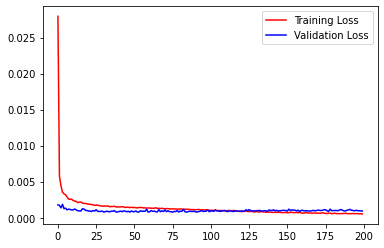

(2168, 6)
The Mean Squared Error is: 12.59751158447979


In [9]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'Wavenet'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Wavenet')
    os.chdir(os.path.join(dest,'Wavenet'))
    print('New Directory Created')

history = atten_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_wavenet.load_weights(filepath_attention)
preds = atten_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('Wavenet Results.xls')